# Location for the new office of our gaming company

For our new company we are looking for the perfect location for our new office.

In our new office we will need space for 87 employees; the employees have reported the following preferences:

- In an area with companies that also do design
- 30% of the company staff have at least 1 child, so schools should be close by.
- The executives want a starbucks close
- Account managers need to travel a lot; easy transport to the airport is important.
- Everyone in the company is between 25 and 40; they like to party.
- The CEO is vegan; some vegan restaurants close by is a must.
- The maintenance guy likes basketball; a court within 10 km would be nice.
- Dobby the office dog needs a groomer

In [1]:
# Importing libaries and functions
from functions import mongo_connection, get_foursquare_data, name_coordinates, map_public_transport, add_places_to_map, get_sgp_office_data #, add_coordinates_to_dataframe
from getpass import getpass
import pandas as pd
import seaborn as sns
import json
from pymongo import MongoClient
import folium
from folium import Choropleth, Circle, Marker, Icon, Map, TileLayer
from folium.plugins import HeatMap, MarkerCluster
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Importing documents 
token = getpass()
df_countries = pd.read_csv(r'../project-III-geospatial-data/data/countries.csv')
df_d7_offices_cord = pd.read_csv(r'../project-III-geospatial-data/data/office_sgp_coordinates.csv')
df_offices_cord = pd.read_csv(r'../project-III-geospatial-data/data/office_all_sgp_coordinates.csv')
geo_json = "../project-III-geospatial-data/data/district.json"
with open(geo_json) as geo_file:
    geo_sgp = json.load(geo_file)


# 1. Selecting the country

First we used our 'Companies' database in Mongo to filter on companies that also do design; as design is a very broad concept we filtered on companies that use the word 'Design' in their company description. In the chart below you will find a chart of the country with the most companies per country following that requierment. 


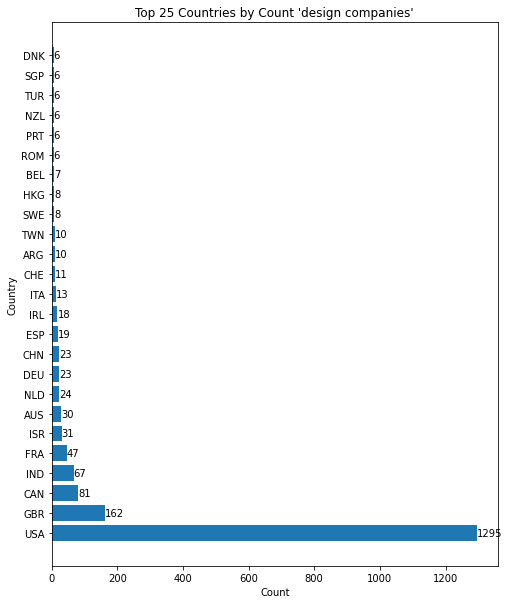

In [4]:
plt.figure(figsize=(8, 10))

top_25 = new_df.sort_values('Count', ascending=False)[:25]

plt.barh(top_25['Country code'], top_25['Count'])

plt.title("Top 25 Countries by Count 'design companies'")
plt.xlabel('Count')
plt.ylabel('Country')
for i, v in enumerate(top_25['Count']):
    plt.text(v, i, str(v), color='black', va='center')
plt.show()

In [3]:
# Connecting to Mongo and filtering on all companies that have 'design' in their company overview
def mongo_connection(database,collection):
    client = MongoClient("localhost:27017")
    db = client[f"{database}"]
    client.list_database_names()
    global c 
    c = db.get_collection(f"{collection}")
    
mongo_connection("Ironhack","companies")
filter_ = {"overview": {"$regex": ".*design*"}}
projection = {"name":1, "offices.latitude":1, "offices.longitude":1, "offices.country_code":1, "_id":0}
new_list = list(c.find(filter_, projection))

#Then we make a new dataframe of the output to see which companies we have and where they are located 
lat_long_list = [(d['name'], d['offices'][0]['latitude'], d['offices'][0]['longitude'], d['offices'][0]['country_code']) for d in new_list if d['offices']]
df = pd.DataFrame(lat_long_list, columns=['Name', 'Latitude', 'Longitude', 'Country code'])

#To see how many companies we have in each country !!MAKE CHART!!
country_counts = df['Country code'].value_counts()
new_df = pd.DataFrame({'Country code': country_counts.index, 'Count': country_counts.values})


In [6]:
# We add a csv which contains information about countries: growth rate, area, density etc
merged_df2 = new_df.merge(df_countries, left_on='Country code', right_on='cca3')
# Dropping the columns we don't need
merged_df2.drop(columns='place',inplace=True)
merged_df2.drop(columns='cca3',inplace=True)
merged_df2.drop(columns='cca2',inplace=True)
merged_df2.drop(columns='ccn3',inplace=True)
merged_df2.drop(columns='region',inplace=True)
merged_df2.drop(columns='Rank',inplace=True)
merged_df2.drop(columns='landAreaKm',inplace=True)
merged_df2.drop(columns='pop2023',inplace=True)
merged_df2.drop(columns='densityMi',inplace=True)

# Calculate score for each country, we take into account the amount of companies per 100km2, the growthrate and the density
merged_df2['Count per 100km2'] = merged_df2['Count'] / (merged_df2['area'] / 100)
merged_df2['score'] = merged_df2['Count'] * merged_df2['growthRate'] * merged_df2['density'] * merged_df2['Count per 100km2']

# Sort dataframe by score in descending order
merged_df2 = merged_df2.sort_values('score', ascending=False)

# Print top 10 countries by score !!!CHART!!!
merged_df2 = merged_df2[['country', 'Count','Count per 100km2', 'growthRate', 'density', 'score']].head(5)



As we want a location where the company has potential to grow, we can not just decide on the graph above but we should take more factors in consideration such as the country size, the growthrate of the economy and the density. By merging the dataframe we took from Mongo with one we imported and calculating a score, we now have a top 5 of countries with the highest score. 

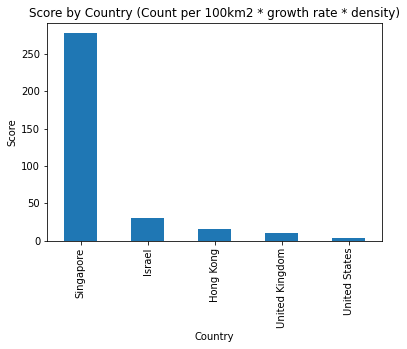

In [7]:
merged_df2[['country', 'score']].plot(kind='bar', x='country', legend=False)
plt.title('Score by Country (Count per 100km2 * growth rate * density)')
plt.xlabel('Country')
plt.ylabel('Score')
plt.show()

In [8]:
# Now we apply the same filter in Mongo for design in overview but we also add country SGP
filter1 = {"overview": {"$regex": ".*design*"}}
filter2 = {"offices.country_code" : "SGP"}
projection = {"name":1, "offices.latitude":1, "offices.longitude":1, "offices.country_code":1, "_id":0}

sgp_list = list(c.find({
            "$and": 
                [filter1, filter2]}, projection))

lat_long_list = [(d['name'], d['offices'][0]['latitude'], d['offices'][0]['longitude'], d['offices'][0]['country_code']) for d in sgp_list if d['offices']]

#A couple of the list do not have coordinates, we add them manually 
sgp_df = pd.DataFrame(lat_long_list, columns=['Name', 'Latitude', 'Longitude', 'Country code'])
sgp_df = df[df['Country code'] == 'SGP']
sgp_df = sgp_df.drop_duplicates(subset=['Name', 'Latitude', 'Longitude'])
new_values = {'Name': ['Ground labs', 'eDLink Services Pte Ltd'], 
              'Latitude': [1.2956954, 1.2758965], 
              'Longitude': [103.8568923, 103.8127756],
              'Country code': ['SGP', 'SGP']}
new_df = pd.DataFrame(new_values)
df = sgp_df.append(new_df)
df = df.dropna()
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df.drop(columns='Country code',inplace=True)
df

,Name,Latitude,Longitude
0,Cubic Lime,1.280574,103.823920
1,Pluit Solutions,1.366447,103.854150
2,Jorbb,1.308655,103.861929
3,Ground labs,1.295695,103.856892
4,eDLink Services Pte Ltd,1.275896,103.812776


The table above are the coordinates from the 5 companies in Singapore. 

In [9]:
#We make a mapp and add an overlay with the districts
singapore_map = Map(location = [1.287953, 103.851784], zoom_start = 11)
folium.Choropleth(
    geo_data=geo_sgp,
    data=df,
    columns=df.columns,
    key_on="feature.properties.name",
).add_to(singapore_map)

#We add the 5 companies in the map
for index, row in df.iterrows():
            icon = Icon(
            color = "blue",
            prefix = "fa",
            icon = 'suitcase',
            icon_color = "white"
        )
            folium.Marker(location=[row['Latitude'], row['Longitude']], tooltip=row['Name'], icon=icon).add_to(singapore_map)
# There are a couple of locations very close to each other, we take 3 locations out of 5 to continue with 
df = df.drop([0, 2])
for index, row in df.iterrows():
    circle = Circle(location=[row['Latitude'], row['Longitude']], radius=1000, color='red', fill=True, fill_opacity=0.3)
    circle.add_to(singapore_map)
    circle = Circle(location=[row['Latitude'], row['Longitude']], radius=500, color='red', fill=True, fill_opacity=0.3)
    circle.add_to(singapore_map)



When adding the 5 locations to the map of Signapore, which is divided into districts, we see that a few offices are very close to each other.
The one in district 3 and 4, and the one in district 7 and 8.

For that reason we continue with 3 locations: 1 in district 3, one in district 7 and one in district 20. Those locations are marked with 2 circles, one for a radius of 500m and another one for 1 km

In [10]:
singapore_map 


# 2. Preferences of employees

To consider the preferences of employees, we are looking at the following points:
- Amount of schools within 1km
- Starbucks within 500m
- Clubs within 1km
- Vegan restaurants within 500m
- Basketball courts within 10km
- Groomer within 1km

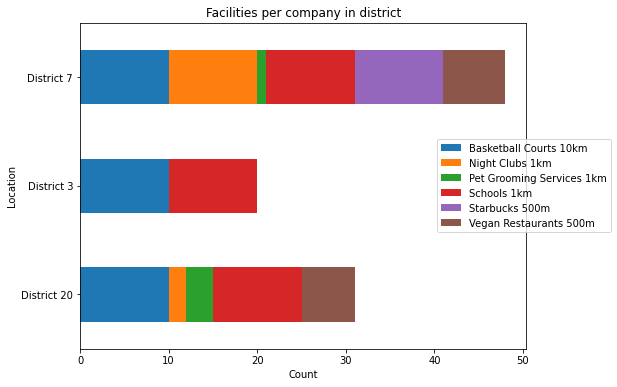

In [11]:
#
list_dict_locations = [
        {"name": "District 20", "lat": "1.366447", "long": "103.854150"},
        {"name": "District 7", "lat": "1.295695", "long": "103.856892"},
        {"name": "District 3", "lat": "1.275896", "long": "103.812776"}
]

def get_foursquare_data():
    base_url = "https://api.foursquare.com/v3/places/search"
    locations = (list_dict_locations)
    headers = {
        "accept": "application/json",
        "Authorization": token
    }
    data_frames = []
    for location in locations:
        links = [
            f"query=school&ll={location['lat']}%2C{location['long']}&radius=1000",
            f"ll={location['lat']}%2C{location['long']}&radius=500&chains=ab4c54c0-d68a-012e-5619-003048cad9da",
            f"ll={location['lat']}%2C{location['long']}&radius=1000&categories=10032",
            f"ll={location['lat']}%2C{location['long']}&radius=500&categories=13377",
            f"ll={location['lat']}%2C{location['long']}&radius=10000&categories=18008",
            f"ll={location['lat']}%2C{location['long']}&radius=1000&categories=11134"
        ]
        counts = []
        for link in links:
            url = f"{base_url}?{link}"
            response = requests.get(url, headers=headers)
            count = len(response.json().get("results", []))
            counts.append(count)
        df = pd.DataFrame({"Category": ["Schools 1km", "Starbucks 500m", "Night Clubs 1km", "Vegan Restaurants 500m", "Basketball Courts 10km", "Pet Grooming Services 1km"], "Count": counts})
        df["Location"] = location["name"]
        data_frames.append(df)
    return pd.concat(data_frames).pivot(index="Location", columns="Category", values="Count")

dataframe_best_district = get_foursquare_data()
dataframe_best_district
# Create a stacked horizontal bar plot
ax = dataframe_best_district.plot(kind='barh', stacked=True, figsize=(8, 6))

# Set the title and axis labels
ax.set_title('Facilities per company in district')
ax.set_xlabel('Count')
ax.set_ylabel('Location')

# Move the legend to the right side
ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))

# Show the plot
plt.show()


Here we already see that probably district 7 would be the best district.

In [12]:
def map_public_transport(_map):
    

        # Train station
        url = "https://api.foursquare.com/v3/places/search?ll=1.244463%2C103.834701&radius=25000&categories=19047"

        headers = {
            "accept": "application/json",
            "Authorization": token
        }

        response = requests.get(url, headers=headers)
        train_list = []
        for i in response.json()["results"]:
            train_list.append(name_coordinates(i))
        
        df_train = pd.DataFrame(train_list)

        for index, row in df_train.iterrows():
            icon = Icon(
            color = "gray",
            fill_opacity = 0.5,
            prefix = "fa",
            icon = 'train',
            icon_color = "white"
        )
            folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=icon).add_to(_map)

        # Airport
        url = "https://api.foursquare.com/v3/places/search?query=Airport&near=Singapore&limit=1"


        headers = {
            "accept": "application/json",
            "Authorization": token
        }

        response = requests.get(url, headers=headers)
        airport_list = []
        for i in response.json()["results"]:
            airport_list.append(name_coordinates(i))
        
        df_airport = pd.DataFrame(airport_list)

        for index, row in df_airport.iterrows():
            icon = Icon(
            color = "gray",
            fill_opacity = 0.5,
            prefix = "fa",
            icon = 'plane',
            icon_color = "white"
        )
            folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=icon).add_to(_map)
        # Metro
        url = "https://api.foursquare.com/v3/places/search?ll=1.244463%2C103.834701&radius=25000&categories=19046"

        headers = {
            "accept": "application/json",
            "Authorization": token
        }

        response = requests.get(url, headers=headers)
        metro_list = []
        for i in response.json()["results"]:
            metro_list.append(name_coordinates(i))
        
        df_metro = pd.DataFrame(metro_list)

        for index, row in df_metro.iterrows():
            icon = Icon(
            color = "gray",
            fill_opacity = 0.5,
            prefix = "fa",
            icon = 'subway',
            icon_color = "white"
        )
            folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=icon).add_to(_map)

            # Metro
        url = "https://api.foursquare.com/v3/places/search?query=Train%20station&ll=1.244463%2C103.834701&radius=25000"

        headers = {
            "accept": "application/json",
            "Authorization": token
        }

        response = requests.get(url, headers=headers)
        tram2_list = []
        for i in response.json()["results"]:
            tram2_list.append(name_coordinates(i))
        
        df_tram2 = pd.DataFrame(tram2_list)

        for index, row in df_tram2.iterrows():
            icon = Icon(
            color = "gray",
            fill_opacity = 0.5,
            prefix = "fa",
            icon = 'train',
            icon_color = "white"
        )
            folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=icon).add_to(_map)

In [13]:
#To see the facilities around we add info about public transport
map_public_transport(singapore_map)

In [14]:
def add_places_to_map(locationslist):
    locations = locationslist
    headers = {
        "accept": "application/json",
        "Authorization": token
    }
    for location in locations:
        lat = location["lat"]
        lon = location["long"]

        # Schools 1000m
        url = f"https://api.foursquare.com/v3/places/search?query=school&ll={lat}%2C{lon}&radius=1000"

        headers = {
            "accept": "application/json",
            "Authorization": token 
        }

        response = requests.get(url, headers=headers)

        school_list = []
        for i in response.json()["results"]:
            school_list.append(name_coordinates(i))
        
        df_school = pd.DataFrame(school_list)

        for index, row in df_school.iterrows():
            icon = Icon(
            color = "red",
            prefix = "fa",
            icon = 'book',
            icon_color = "white"
        )
            folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=icon).add_to(singapore_map)
# Starbucks 500m
        url = f"https://api.foursquare.com/v3/places/search?ll={lat}%2C{lon}&radius=500&chains=ab4c54c0-d68a-012e-5619-003048cad9da"

        headers = {
            "accept": "application/json",
            "Authorization": token
        }

        response = requests.get(url, headers=headers)

        starbucks_list = []
        for i in response.json()["results"]:
            starbucks_list.append(name_coordinates(i))
        
        df_starbucks = pd.DataFrame(starbucks_list)

        for index, row in df_starbucks.iterrows():
            icon = Icon(
            color = "beige",
            prefix = "fa",
            icon = 'coffee',
            icon_color = "white"
        )
            folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=icon).add_to(singapore_map)
# Nightclub 1km
        url = f"https://api.foursquare.com/v3/places/search?ll={lat}%2C{lon}&radius=1000&categories=10032"

        headers = {
            "accept": "application/json",
            "Authorization": token
        }

        response = requests.get(url, headers=headers)

        nightclub_list = []
        for i in response.json()["results"]:
            nightclub_list.append(name_coordinates(i))
        
        df_nightclub = pd.DataFrame(nightclub_list)

        for index, row in df_nightclub.iterrows():
            icon = Icon(
            color = "purple",
            prefix = "fa",
            icon = 'music',
            icon_color = "white"
        )
            folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=icon).add_to(singapore_map)

        #Vegan restaurant 500m
        url = f"https://api.foursquare.com/v3/places/search?ll={lat}%2C{lon}&radius=500&categories=13377"

        headers = {
        "accept": "application/json",
        "Authorization": token
        }

        response = requests.get(url, headers=headers)

        vegan_rest_list = []
        for i in response.json()["results"]:
            vegan_rest_list.append(name_coordinates(i))

        vegan_rest_list = []
        for i in response.json()["results"]:
            vegan_rest_list.append(name_coordinates(i))
            
        df_vegan_rest = pd.DataFrame(vegan_rest_list)

        for index, row in df_vegan_rest.iterrows():
            icon = Icon(
            color = "black",
            #opacity = 0.1,
            prefix = "fa", #font-awesome
            icon = 'cutlery',
            icon_color = "white"
        )
            folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=icon).add_to(singapore_map)

        #Basketball 10km
        url = f"https://api.foursquare.com/v3/places/search?ll={lat}%2C{lon}&radius=10000&categories=18008"

        headers = {
        "accept": "application/json",
        "Authorization": token
        }

        response = requests.get(url, headers=headers)

        basketball_list = []
        for i in response.json()["results"]:
            basketball_list.append(name_coordinates(i))
            
        df_basketball = pd.DataFrame(basketball_list)

        for index, row in df_basketball.iterrows():
            icon = Icon(
            color = "orange",
            #opacity = 0.1,
            prefix = "fa", #font-awesome
            icon = 'futbol',
            icon_color = "white"
        )
            folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=icon).add_to(singapore_map)

        #Groomer 1km
        url = f"https://api.foursquare.com/v3/places/search?ll={lat}%2C{lon}&radius=1000&categories=11134"

        headers = {
        "accept": "application/json",
        "Authorization": token
        }

        response = requests.get(url, headers=headers)

        groomer_list = []
        for i in response.json()["results"]:
            groomer_list.append(name_coordinates(i))
            
        df_groomer = pd.DataFrame(groomer_list)

        for index, row in df_groomer.iterrows():
            icon = Icon(
            color = "green",
            #opacity = 0.1,
            prefix = "fa", #font-awesome
            icon = 'paw',
            icon_color = "white"
        )
            folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=icon).add_to(singapore_map)
        return singapore_map

def add_places_to_map(locationslist):
    locations = locationslist
    headers = {
        "accept": "application/json",
        "Authorization": token
    }
    for location in locations:
        lat = location["lat"]
        lon = location["long"]

        # Schools 1000m
        url = f"https://api.foursquare.com/v3/places/search?query=school&ll={lat}%2C{lon}&radius=1000"

        headers = {
            "accept": "application/json",
            "Authorization": token 
        }

        response = requests.get(url, headers=headers)

        school_list = []
        for i in response.json()["results"]:
            school_list.append(name_coordinates(i))
        
        df_school = pd.DataFrame(school_list)

        for index, row in df_school.iterrows():
            icon = Icon(
            color = "red",
            prefix = "fa",
            icon = 'book',
            icon_color = "white"
        )
            folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=icon).add_to(singapore_map)
# Starbucks 500m
        url = f"https://api.foursquare.com/v3/places/search?ll={lat}%2C{lon}&radius=500&chains=ab4c54c0-d68a-012e-5619-003048cad9da"

        headers = {
            "accept": "application/json",
            "Authorization": token
        }

        response = requests.get(url, headers=headers)

        starbucks_list = []
        for i in response.json()["results"]:
            starbucks_list.append(name_coordinates(i))
        
        df_starbucks = pd.DataFrame(starbucks_list)

        for index, row in df_starbucks.iterrows():
            icon = Icon(
            color = "beige",
            prefix = "fa",
            icon = 'coffee',
            icon_color = "white"
        )
            folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=icon).add_to(singapore_map)
# Nightclub 1km
        url = f"https://api.foursquare.com/v3/places/search?ll={lat}%2C{lon}&radius=1000&categories=10032"

        headers = {
            "accept": "application/json",
            "Authorization": token
        }

        response = requests.get(url, headers=headers)

        nightclub_list = []
        for i in response.json()["results"]:
            nightclub_list.append(name_coordinates(i))
        
        df_nightclub = pd.DataFrame(nightclub_list)

        for index, row in df_nightclub.iterrows():
            icon = Icon(
            color = "purple",
            prefix = "fa",
            icon = 'music',
            icon_color = "white"
        )
            folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=icon).add_to(singapore_map)

        #Vegan restaurant 500m
        url = f"https://api.foursquare.com/v3/places/search?ll={lat}%2C{lon}&radius=500&categories=13377"

        headers = {
        "accept": "application/json",
        "Authorization": token
        }

        response = requests.get(url, headers=headers)

        vegan_rest_list = []
        for i in response.json()["results"]:
            vegan_rest_list.append(name_coordinates(i))

        vegan_rest_list = []
        for i in response.json()["results"]:
            vegan_rest_list.append(name_coordinates(i))
            
        df_vegan_rest = pd.DataFrame(vegan_rest_list)

        for index, row in df_vegan_rest.iterrows():
            icon = Icon(
            color = "black",
            #opacity = 0.1,
            prefix = "fa", #font-awesome
            icon = 'cutlery',
            icon_color = "white"
        )
            folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=icon).add_to(singapore_map)

        #Basketball 10km
        url = f"https://api.foursquare.com/v3/places/search?ll={lat}%2C{lon}&radius=10000&categories=18008"

        headers = {
        "accept": "application/json",
        "Authorization": token
        }

        response = requests.get(url, headers=headers)

        basketball_list = []
        for i in response.json()["results"]:
            basketball_list.append(name_coordinates(i))
            
        df_basketball = pd.DataFrame(basketball_list)

        for index, row in df_basketball.iterrows():
            icon = Icon(
            color = "orange",
            #opacity = 0.1,
            prefix = "fa", #font-awesome
            icon = 'futbol',
            icon_color = "white"
        )
            folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=icon).add_to(singapore_map)

        #Groomer 1km
        url = f"https://api.foursquare.com/v3/places/search?ll={lat}%2C{lon}&radius=1000&categories=11134"

        headers = {
        "accept": "application/json",
        "Authorization": token
        }

        response = requests.get(url, headers=headers)

        groomer_list = []
        for i in response.json()["results"]:
            groomer_list.append(name_coordinates(i))
            
        df_groomer = pd.DataFrame(groomer_list)

        for index, row in df_groomer.iterrows():
            icon = Icon(
            color = "green",
            #opacity = 0.1,
            prefix = "fa", #font-awesome
            icon = 'paw',
            icon_color = "white"
        )
            folium.Marker([row['lat'], row['lon']], popup=row['name'], icon=icon).add_to(singapore_map)
        return singapore_map


When we add markers to the map, we can easily see the distribution of public transport and facilities the employees suggested.

In [15]:
# And we run the function to add the requierments of the employees
list_dict_locations1 = [
        {"name": "District 20", "lat": "1.366447", "long": "103.854150"}       
]
list_dict_locations2 = [       
        {"name": "District 3", "lat": "1.275896", "long": "103.812776"}
]
list_dict_locations3 = [
        {"name": "District 7", "lat": "1.295695", "long": "103.856892"}
]
add_places_to_map(list_dict_locations1)
add_places_to_map(list_dict_locations2)
add_places_to_map(list_dict_locations3)


# 3. Finding an empty office

Now we have a district that would be the best location for our new office; we need to find an empty office that is big enough for 87 people. To find one, we scraped data from empty offices that are available for rent on '99.co'. As we have a lot of data now, we can compare the average price of offices per district.


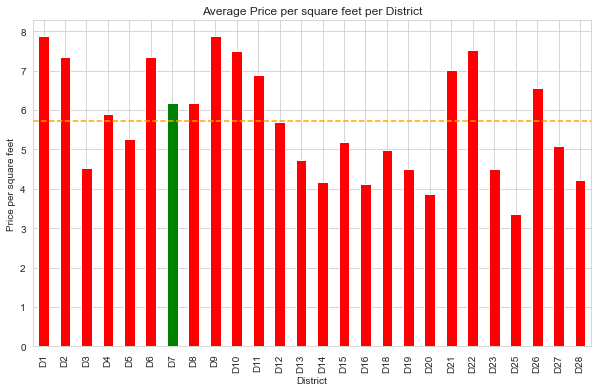

In [21]:
df_offices_cord.sample(4)
district_mean = df_offices_cord.groupby('District')['Price per m2'].mean()

#df_offices_cord.drop(118, inplace=True)
#df_offices_cord.drop(24, inplace=True)

districts = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'D18', 'D19', 'D20', 'D21', 'D22', 'D23', 'D25', 'D26', 'D27', 'D28']
colors = ['g' if i == 'D7' else 'r' for i in districts]

fig, ax = plt.subplots(figsize=(10, 6))
district_mean.loc[districts].plot(kind='bar', color=colors, ax=ax)

plt.title('Average Price per square feet per District')
mean_price = district_mean.mean()
ax.axhline(mean_price, color='orange', linestyle='--', label='Mean Price')
plt.xlabel('District')
plt.ylabel('Price per square feet')
plt.show()

The boxplot below shows more information about the price per square feet in District 7

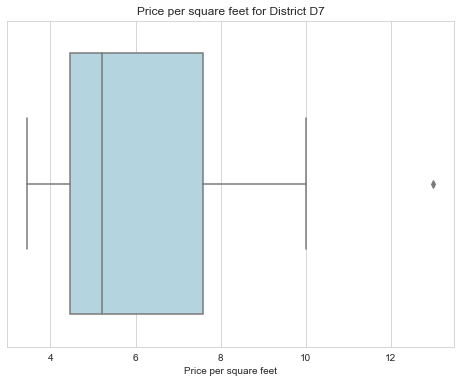

In [22]:
df_d7 = df_offices_cord[df_offices_cord['District'] == 'D7']
sns.set_style('whitegrid')
plt.figure(figsize=(8,6))
ax = sns.boxplot(x='Price per m2', data=df_d7, color='lightblue')
ax.set_title('Price per square feet for District D7')
ax.set_xlabel('Price per square feet')
plt.show()

Below we see the offices that are available for rent. Per office it lists the name, the price per month (in S$), square feet and the price per square feet. 

In [23]:
for index, row in df_d7_offices_cord.iterrows():
            icon = Icon(
            color = "lightblue",
            prefix = "fa",
            icon = 'building',
            icon_color = "black"
        )
            folium.Marker(location=[row['Latitude'], row['Longitude']], popup=[row['Name'], row['Price ($) p/m'], row['Size (m2)'], row['Price per m2'], row['Link']], icon=icon).add_to(singapore_map)

singapore_map


From all the offices available, there is only one office available that is suitable for 85 employees:

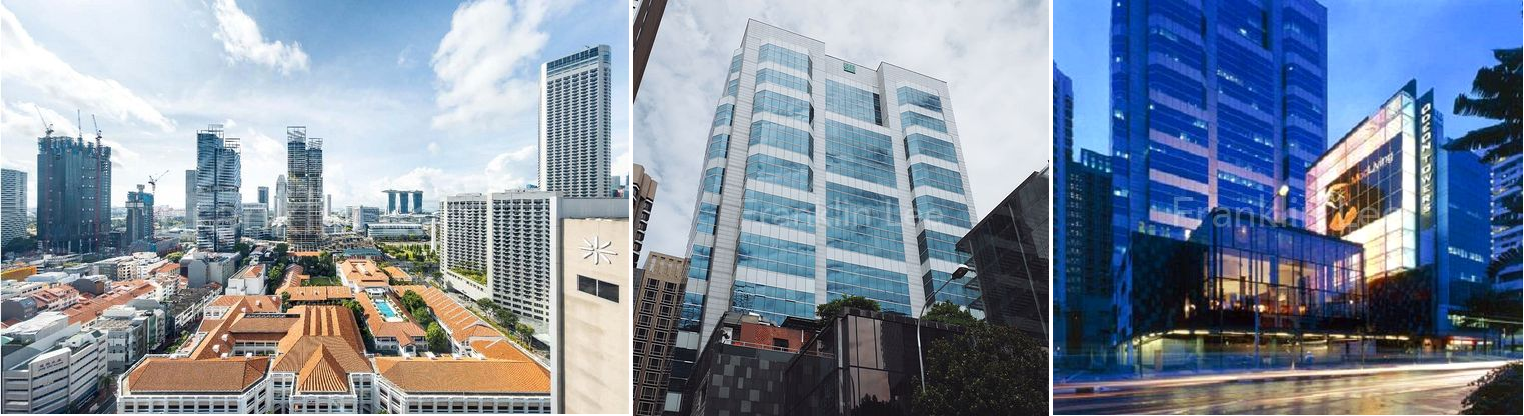

Office in Odeon Towers

https://www.99.co/singapore/commercial/rent/property/odeon-towers-office-WKatJHog8GMU2uWcBYzDCb

Coordinates new office: 1.2995192,103.8473046

In [19]:
icon = Icon(
    color = "white",
    prefix = "fa", #font-awesome
    icon = 'trophy',
    icon_color = "black"
)

Winner = Marker(
    location = [1.29624,103.85328],
    tooltip = "ODEON TOWERS",
    icon = icon
)

Winner.add_to(singapore_map)
singapore_map
